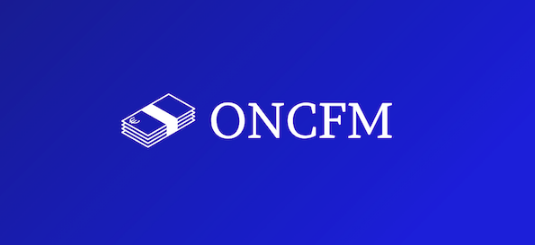

### Sommaire:

* [I) Introduction](#chapter1)

    * [1) Importation des librairies et déclarations des fonctions](#section_1_1)
    * [2) Importation et exploration des données](#section_1_2)
    
* [II) Imputation des valeurs manquantes](#chapter2)

    * [1) Modèle - Regression Linéaire](#section_2_1)
    * [2) Application du modèle](#section_2_2)
    
* [III) Recherche d'un modèle de prédiction](#chapter3)
    * [1) Dummy Classifier](#section_3_1)
    * [2) K-Means](#section_3_2)
    * [3) Regression Logistique](#section_3_3)
    
* [IV) Choix du modèle et déploiement](#chapter4)

## I) Introduction <a class="anchor" id="chapter1"></a>

L’Organisation nationale de lutte contre le faux-monnayage, ou ONCFM, est une organisation publique ayant pour objectif de mettre en place des méthodes d’identification des contrefaçons des billets en euros. Dans le cadre de cette lutte, elle souhaite mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets.

Lorsqu’un billet arrive, une machine consigne l’ensemble de ses caractéristiques géométriques. Au travers d'années de lutte, des différences de dimensions entre les vrais et les faux billets ont été observés. Ces différences sont difficilement notables à l’oeil nu, mais une machine devrait sans problème arriver à les différencier.
L'objectif est ainsi de construire un algorithme qui, à partir des caractéristiques géométriques d’un billet, serait capable de définir si ce dernier est un vrai ou un faux billet.

### 1. Importation des librairies et déclarations des fonctions: <a class="anchor" id="section_1_1"></a>

> **Librairies:**

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, make_scorer, recall_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.linear_model import LogisticRegression

from scipy.stats import t, shapiro

> **Fonctions:**

In [2]:
def score(estimator):
    
    """calcule et affiche les accuracy scores d'entrainement et de test"""
    
    tr_score = round(estimator.score(X_train, y_train), 4)
    te_score = round(estimator.score(X_test, y_test),4)
    
    print("score train:", tr_score, "score test:", te_score)

In [3]:
def confusion(y_test, y_pred):
    
    """affiche une matrice de confusion stylisée"""
    
    mat = confusion_matrix(y_test, y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [f"pred_{i}" for i in mat.columns]
    mat.index = [f"test_{i}" for i in mat.index]

    return mat

In [4]:
def resultize(grid):
    
    """affiche grid.cv_results_ sous forme de dataframe retravaillé"""
    
    res = grid.cv_results_
    res = pd.DataFrame(res)
    cols = [i for i in res.columns if "split" not in i]
    res = res[cols]
    res = res.sort_values("rank_test_spec_score")
    
    return res

### 2. Importation et exploration des données: <a class="anchor" id="section_1_2"></a>

In [5]:
# Importation des données "production" qui serviront pour tester les modèles finaux:

data_prod = pd.read_csv("billets_production.csv")
data_prod

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [6]:
# Importation des données de travail:
data = pd.read_csv("billets.csv", delimiter=";")
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [7]:
# études des variables:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [8]:
data.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Les données sont globalement très complètes et ne présentent pas de valeurs très aberrantes. Seule la variable "margin_low" présente des valeurs manquantes qu'ils faudra traiter.

In [9]:
# répartition des vrais/faux
data["is_genuine"].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

***

> **Visualisation:**

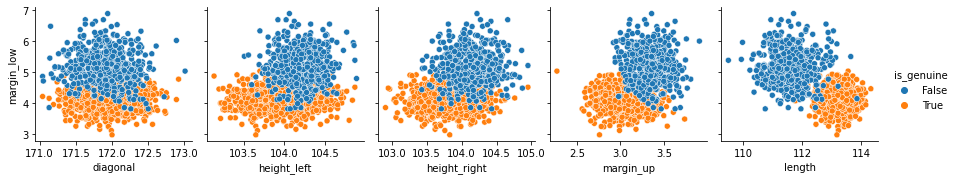

In [10]:
# mise en parralèle de "margin_low" et des autres variables afin d'observer une éventuelle relation:
sns.pairplot(data,
             x_vars=["diagonal","height_left", "height_right", "margin_up", "length"], 
             y_vars="margin_low", 
             hue="is_genuine")

***

## II) Imputation des valeurs manquantes <a class="anchor" id="chapter2"></a>

Ces dernières ne représentent qu'une petite partie de notre jeu de données et nous pourrions tout à fait supprimer les individus contenant des informations manquantes.

Cependant nous souhaitons garder le maximum d'informations possible et souhaitons ainsi imputer ces données manquantes. Une imputation simple par la moyenne est possible mais il est possible que d'autres méthodes permettent l'obtention de résultats plus précis:

### 1. Modèle - Regression Linéaire: <a class="anchor" id="section_2_1"></a>

Comme cela nous a été conseillé par notre prédecesseur nous allons imputer les valeurs manquantes de notre jeu de données à l'aide d'un algorithme de **régresssion linéaire**. Nous avons plusieurs variables potentiellement influentes, de ce fait nous utiliserons une régression linéaire **multiple**.

In [11]:
# On isole les données non-nulles et quantitatives:
data_full = data[(~data["margin_low"].isna())]
data_full = data_full.drop(columns="is_genuine")
data_full.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


***

Grâce à la librairie *statsmodel* nous pouvons directement réaliser la régression linéraire multiple. Nous nous intéresserons principelement à la **significativité des paramètres/variables** séléctionné(e)s et au **R²** afin d'évaluer si notre modèle peut être améliorer:

In [12]:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=data_full).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Mon, 15 May 2023   Prob (F-statistic):          2.60e-202
Time:                        13:10:31   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

Toutes les paramètres disponibles dans le jeu de données sont **statistiquement significatifs** (tous les p < 0.05).

On note aussi que le $R²$ et le $R²$ ajusté sont égaux à 0.48. Notre modèle n'explique pas une majeure partie de la variance et ceci n'est pas très étonnant au vue de la dispersion de données.

Ce modèle peut donc potentiellement être améliorer. Étudions les résultats obtenus pour voir ce que l'on peut faire:

### **Vérifier la colinéarité des variables:**

Le *summary* nous l'indique, il est possible que plusieurs de nos variables soient colinéaires entre elles:

In [13]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0136128990686315,
 1.1382605736082538,
 1.2301145155560338,
 1.404403778184362,
 1.5769501453665806]

Tous les coefficients sont inférieurs à 10. Nous n'avons donc **pas de problème de colinéarité**.

### **Tester l'homoscédasticité:**

Teston ici la constance de la variance des résidus:

In [14]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print("p_value test Breusch Pagan:", pval)

p_value test Breusch Pagan: 7.759535216194938e-16


La p_value est très inférieure à 5%, on rejette donc H0, hypothèse selon laquelle les variances sont constantes. Nous sommes donc en cas d'**hétéroscédasticité**.

### **Tester la normalité des résidus:**

Pour tester la normalité des résidus, on effectue un test de Shapiro-Wilk:

In [15]:
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9857879281044006, pvalue=8.536943374437556e-11)

Ici, la p_value est très inférieure à 0.05. L'hypothèse de normalité est donc rejetée.

***

L'homoscédasticité et la normalité des résidus ont été rejetés, ce qui ne remet pas en cause le fonctionnement du modèle mais peut biaiser quelques peu son estimateur. Dans notre cas étant donné la taille et la "propreté" de notre jeu de données nous n'utiliserons ces indicateurs qu'à titre informatif.

### **Analyses des valeurs atypiques et/ou influentes:**

In [16]:
alpha = 0.05
n = data_full.shape[0] #nombre d'individus
p = 5 # nombre de variables

reg_multi_analyses = pd.DataFrame({"obs":np.arange(1, n+1)})
reg_multi_analyses.index = data_full.index

On s'intéresse dans un premier temps aux valeurs atypiques sur les variables explicatives:

> **Calcul des leviers:**

In [17]:
reg_multi_analyses["levier"] = reg_multi.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

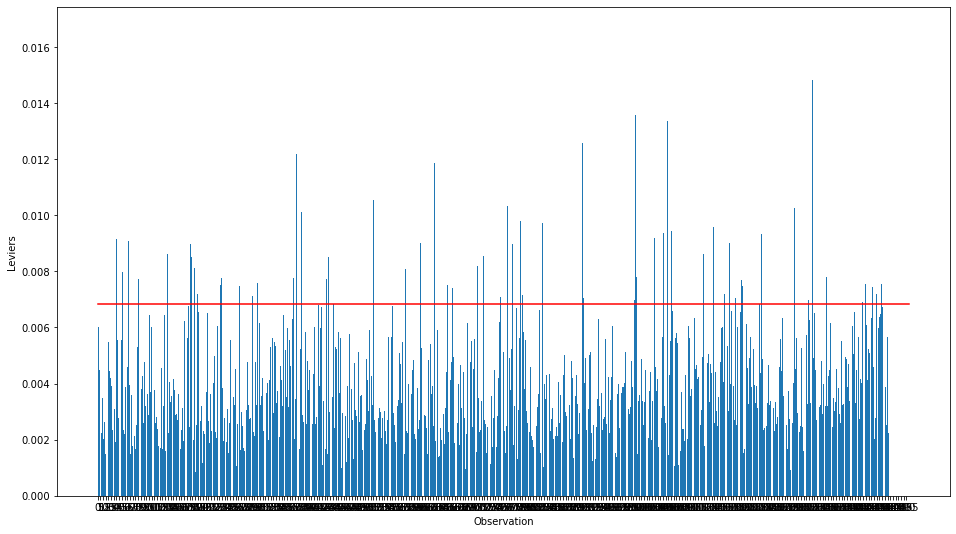

In [18]:
plt.figure(figsize=(16,9))
plt.bar(reg_multi_analyses["obs"], reg_multi_analyses["levier"])
plt.xticks(np.arange(0, 1500, step=5))
plt.xlabel("Observation")
plt.ylabel("Leviers")
plt.plot([0, 1500], [seuil_levier, seuil_levier], color='r')
plt.show()

On peut isoler les individus dont l'atypicité est notoire, c'est à dire supérieur au seuil fixé:

In [19]:
out_lev = reg_multi_analyses.loc[reg_multi_analyses["levier"] > seuil_levier]
out_lev.shape

(148, 2)

***
On s'intéresse aussi au valeurs atypiques sur la variable à expliquer, ici margin_low:

> **Calcul des résidus studentisés:**

In [20]:
reg_multi_analyses["rstudent"] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

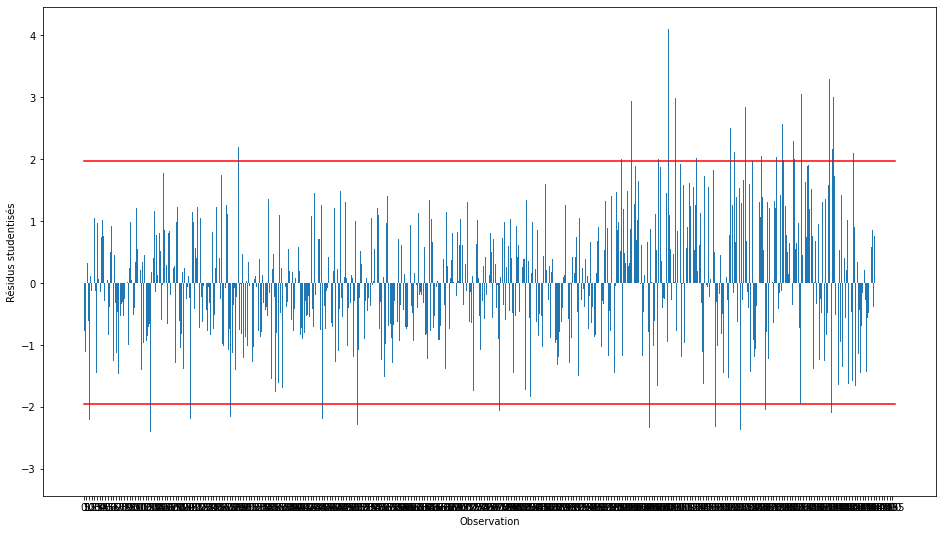

In [21]:
plt.figure(figsize=(16,9))
plt.bar(reg_multi_analyses["obs"], reg_multi_analyses["rstudent"])
plt.xticks(np.arange(0, 1500, step=5))
plt.xlabel("Observation")
plt.ylabel("Résidus studentisés")
plt.plot([0, 1500], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1500], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

In [22]:
out_stu = reg_multi_analyses.loc[(reg_multi_analyses["rstudent"] > seuil_rstudent) |
                                 (reg_multi_analyses["rstudent"] < -seuil_rstudent)]
out_stu.shape

(78, 3)

***
Des points atypiques sont éloignés de la majeure partie des autres points mais ne sont pas pour autant déterminants dans la détermination de la droite de régression.

Pour avoir une idée de l'influence de chacun d'entre eux nous pouvons utiliser la **distance de Cook**.

> **Calcul de la distance de Cook:**

In [23]:
influence = reg_multi.get_influence().summary_frame()

In [24]:
reg_multi_analyses["dcooks"] = influence["cooks_d"]
seuil_dcook = 4/(n-p)

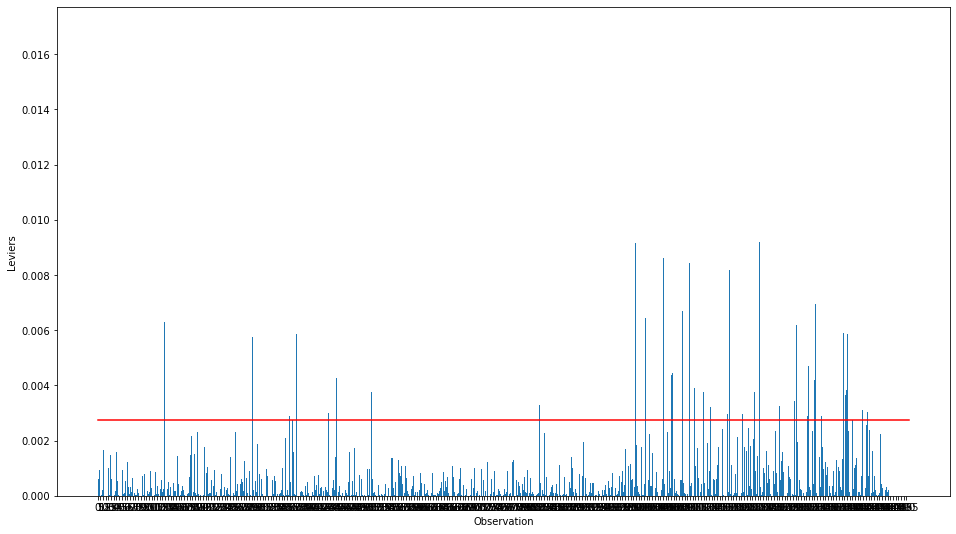

In [25]:
plt.figure(figsize=(16,9))
plt.bar(reg_multi_analyses["obs"], reg_multi_analyses["dcooks"])
plt.xticks(np.arange(0, 1500, step=5))
plt.xlabel("Observation")
plt.ylabel("Leviers")
plt.plot([0, 1500], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [26]:
out_cook = reg_multi_analyses.loc[reg_multi_analyses["dcooks"] > seuil_dcook]
out_cook.shape

(86, 4)

***
Des points influents ne sont pas nécessairement néfastes. En revanche des points atypiques (éloignés) et influents peuvent géner l'optimisation de notre modèle.

Mettons en parallèle les résultats obtenus précédemment:

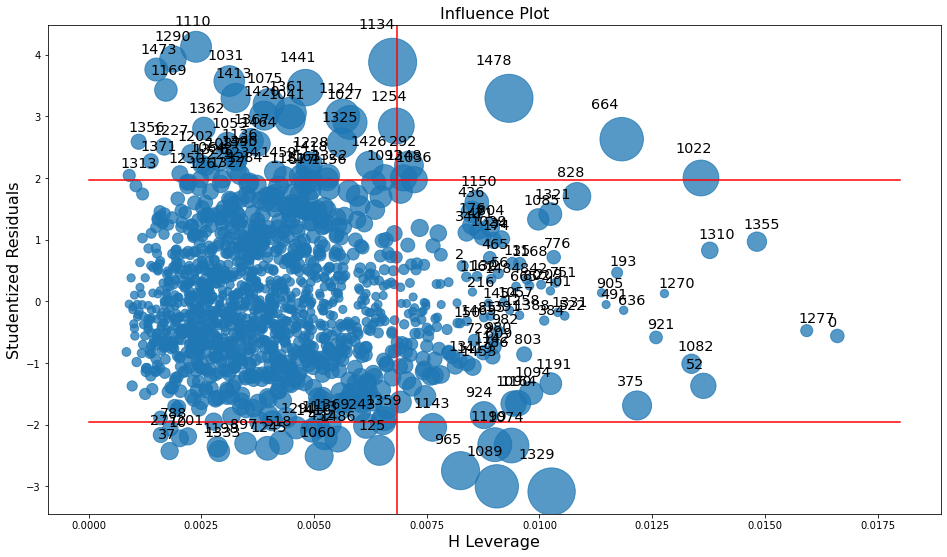

In [27]:
fig, ax = plt.subplots(figsize=(16,9))
fig = sm.graphics.influence_plot(reg_multi,
                                 criterion="cooks", 
                                 ax=ax)

plt.axvline(x = seuil_levier, color = "r")
plt.plot([0, 0.018], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 0.018], [-seuil_rstudent, -seuil_rstudent], color='r')

plt.show()

Les points situés dans en haut et en bas de la "zone droite" présentent des caractéristiques d'atypicité et d'influence importantes.

Isolons les:

In [28]:
out = pd.merge(pd.merge(out_lev, out_stu, left_index=True, right_index=True), out_cook, left_index=True, right_index=True)
out.index

Int64Index([292, 664, 965, 1022, 1036, 1074, 1089, 1143, 1199, 1329, 1348,
            1478],
           dtype='int64')

In [29]:
print(seuil_levier, seuil_rstudent, seuil_dcook)

0.00683526999316473 1.9615935038492915 0.0027434842249657062


On retient donc 12 points dont l'atypicité et l'influence sont au delà des seuils que nous avions fixés.

Réévaluons notre modèle sans ces individus:

In [30]:
data_full_ajust = data_full.drop(out.index)
data_full_ajust.shape

(1451, 6)

In [31]:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=data_full_ajust).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     282.9
Date:                Mon, 15 May 2023   Prob (F-statistic):          3.57e-211
Time:                        13:10:48   Log-Likelihood:                -960.51
No. Observations:                1451   AIC:                             1933.
Df Residuals:                    1445   BIC:                             1965.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       24.6626      9.469      2.604   

Nous avons réussi à améliorer notre modèle, le $R²$ ajusté passant de 0.476 à 0.493.

Ce modèle reste imparfait, comme nous avons pu le voir, mais dans le cadre actuel nous nous en satisferons.

***

Nous allons donc pouvoir utiliser ce modèle afin de prédire les 37 valeurs de "margin_low" manquantes:

### 2. Application du modèle: <a class="anchor" id="section_2_2"></a>

In [32]:
# on récupère les prévision de notre modèle:
nan = data[data["margin_low"].isna()]
prev = reg_multi.predict(nan)
prev = pd.DataFrame(prev)
prev

,0
72,4.321254
99,4.391126
151,4.397334
197,4.325527
241,4.653385
251,3.792494
284,4.176222
334,4.116240
410,4.121655
413,4.150483


In [33]:
# on intègre ces prévisions dans notre dataset afin d'obtenir un jeu de données complet:
data_comp = data
for i in prev.index:
    data_comp.loc[data_comp.index.isin([i]), "margin_low"] = prev[prev.index.isin([i])].values
data_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [89]:
data_comp.to_csv(r'C:\Users\MSI\P10_OpenClassrooms\data_comp_p10.csv', index = False)

***

Maintenant que nous avons un jeu de données complet nous pouvons nous pencher sur la réalisation d'un modèle qui nous permettra de prédire l'authenticité, ou non, d'autres billets.

Pour cela nous comparerons les résultats de deux modèles différents, l'un basé sur une **Régression Logistique** puisque on cherche ici à prédire le caractère binaire vrai/faux des indiividus, l'autre basé sur un algorithme **K-Means** à 2 clusters, vrai/faux.

## III) Recherche d'un modèle de prédiction <a class="anchor" id="chapter3"></a>

> **Exploration des données:**

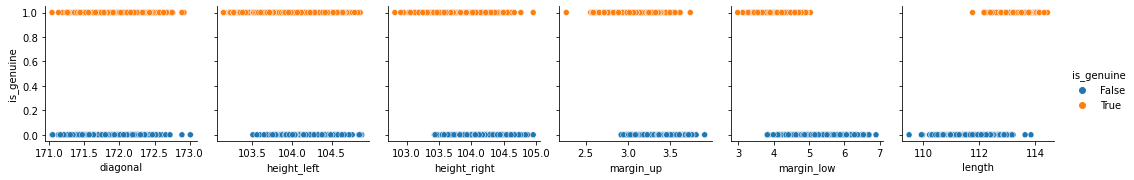

In [34]:
sns.pairplot(data_comp,
             x_vars=["diagonal","height_left", "height_right", "margin_up", "margin_low", "length"], 
             y_vars="is_genuine", 
             kind="scatter",
             hue="is_genuine")

In [35]:
data_viz = data_comp[["is_genuine","length"]]
data_viz["cl_length"] = pd.cut(data_viz["length"], bins = np.arange(109, 115, 0.5), right=False)
prop = pd.crosstab(data_viz["cl_length"], data_viz['is_genuine'], normalize='index')
prop_genuine = pd.DataFrame(data = {"length": np.concatenate((np.array([109]), 
                                                       np.repeat(np.arange(109.5, 114.5 ,0.5), repeats=2), 
                                                       np.array([114.5])), axis=0),
                                "prop_genuine": np.repeat(prop.loc[:,1].values, repeats=2)})

C:\Users\MSI\AppData\Local\Temp\ipykernel_2316\1905250659.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_viz["cl_length"] = pd.cut(data_viz["length"], bins = np.arange(109, 115, 0.5), right=False)


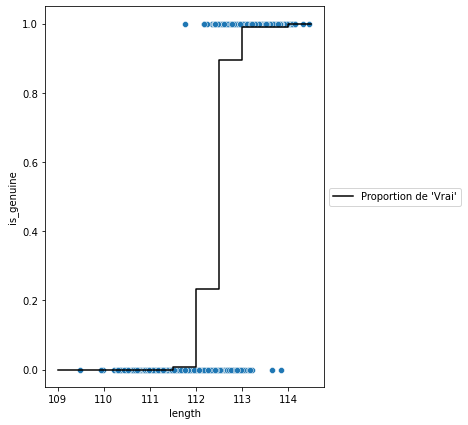

In [36]:
plt.figure(figsize=(5,7))
ax = sns.scatterplot(x="length", y="is_genuine", data=data_viz)
plt.plot(prop_genuine["length"], prop_genuine['prop_genuine'], color='black', label="Proportion de 'Vrai'")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Nos données sont bien séparées en 2 groupes, Vrai & Faux. La forme proche d'une **courbe sigmoïde** qui représente l'évolution de proportion de "Vrai" confirme que la régression logistique peut-être un modèle efficace pour prédire la variable "is_genuine".

> **Normalisation des données:**

Afin que nos modèles soient les plus efficaces et afin de réduire l'impact de certaines variables nous procédons à la standardisation des données:

In [37]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_comp[["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]])
data_scaled = pd.DataFrame(data_scaled, index=data_comp.index, columns=["diagonal", 
                                                                        "height_left",
                                                                        "height_right",
                                                                        "margin_low", 
                                                                        "margin_up", 
                                                                        "length"])
data_scaled["is_genuine"] = data_comp["is_genuine"]
data_scaled

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine
0,-0.486540,2.774123,3.163240,0.055454,-1.128325,0.173651,True
1,-1.633729,-2.236535,-0.799668,-1.081634,-0.696799,0.471666,True
2,2.397823,1.504756,-1.291191,-0.126480,-0.912562,0.551901,True
3,-1.961498,-0.399294,0.060498,-1.309052,-0.610494,0.953075,True
4,-0.748754,0.836669,-1.414072,-0.672283,1.417677,-0.158750,True
...,...,...,...,...,...,...,...
1495,-0.683201,1.170713,0.767063,-0.096158,-0.265273,-1.602978,False
1496,0.758981,2.005822,1.596509,1.192542,0.942999,-1.958303,False
1497,-0.519316,-0.065250,0.613462,1.556410,0.899846,-0.835016,False
1498,0.332882,0.836669,0.429141,1.040930,1.331372,-0.491152,False


In [38]:
data_scaled_X = data_scaled.drop(columns="is_genuine")

> **Création des jeux Train & Test:**

Nous divisons notre jeu de données en 2 groupes:
- un jeu "train" destiné à entrainer les modèles
- un jeu "test" destiné à évaluer les performances des modèles

Le jeu "train" représentera 80% des données et le jeu "test" les 20% restants.

In [39]:
X = data_scaled.drop(columns="is_genuine")
y = data_scaled.is_genuine

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size=0.8,
                                                    random_state=42)

In [41]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 6), (300, 6), (1200,), (300,))

### 1. Dummy Classifier: <a class="anchor" id="section_3_1"></a>

Ce modèle va simplement prédire les résultats de manière quasi aléatoire. Son utilisation sert simplement a obtenir un point de référence sur lequel nous baser pour comparer avec les futurs modèles:

In [42]:
estimator = DummyClassifier(strategy="most_frequent")
estimator.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [43]:
y_pred = estimator.predict(X_test)
pd.Series(y_pred).value_counts()

True    300
dtype: int64

In [44]:
y_test.value_counts()

True     190
False    110
Name: is_genuine, dtype: int64

Comme indiqué par l'hyperparamètre "most_frequent", le DummyClassifier a seulement renvoyé la valeur la plus fréquente dans le jeu "test".

In [45]:
score(estimator)

score train: 0.675 score test: 0.6333


Nous avons ici le score le plus basique pour une modèlisation de nos données.

### **Étude des résultats:**

> **Matrice de confusion:**

Cette matrice permet de visuellement mettre en parallèle les prédictions et les vraies valeurs:

In [46]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,0,110
test_1,0,190


Comme vu plus tôt, le modèle n'a renvoyé que des "vrais" dans ses prédictions.

> **Courbe de ROC:**

Cette courbe résume les scores de Sensibilité et de Spécifictié de toutes les matrices de confusion de tous les seuils possibles. Ici, quelque soit le threshold choisi on ne s'attend pas à un résultat pertinent du fait de la méthode employé.

L'AUC, l'aire sous la courbe ROC, permet de mesurer l'efficacité du modèle. Encore une fois on ne s'attend pas à un résultat probant.

In [47]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5

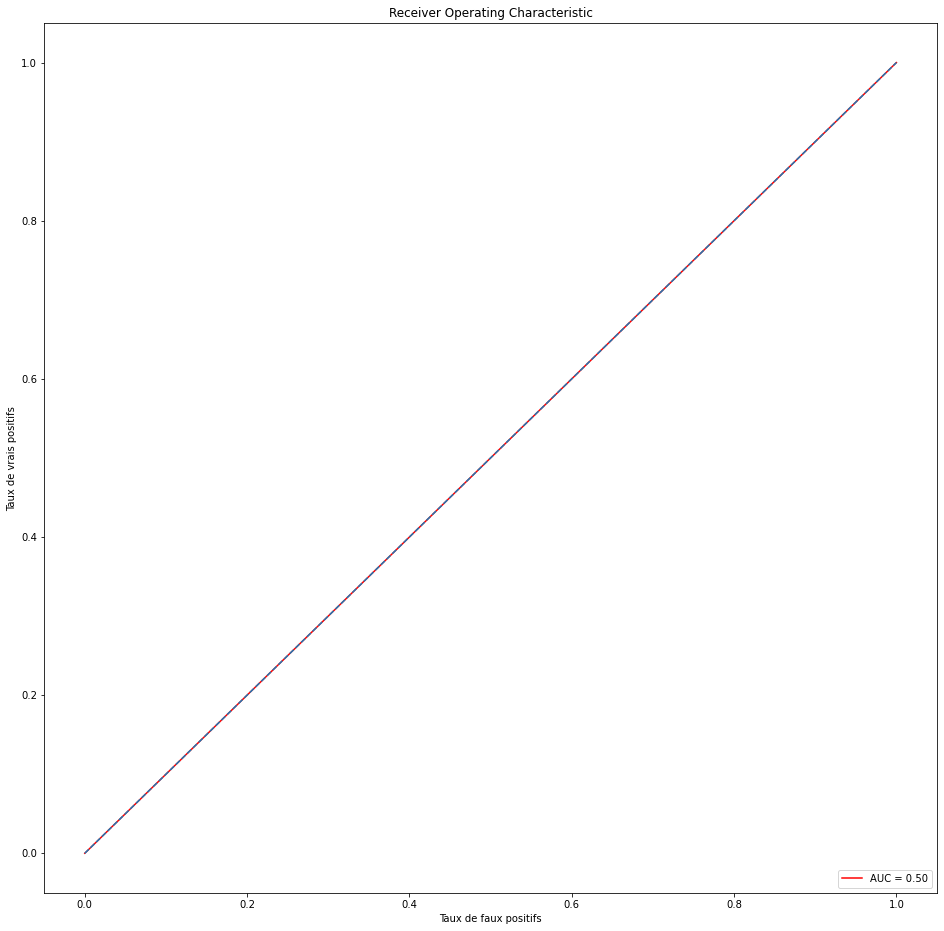

In [48]:
plt.figure(figsize=(16,16))
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate, color="red", label = "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.axis("tight")
plt.ylabel("Taux de vrais positifs")
plt.xlabel("Taux de faux positifs")
plt.show()

La courbe ROC se confond avec la diagonale et l'AUC n'est que de 0.5, indiquant le côté "aléatoire" de la méthode utilisé pour ce DummyClassifier.

***

Maintenant que nous avons un modèle et un score de base, nous pouvons nous intéresser à des méthodes qui permettraient de mieux modéliser et prédire le phénomène. 

### 2. K-Means: <a class="anchor" id="section_3_2"></a>

In [49]:
# on sait ici qu'on ne cherche que 2 clusters - Vrai/Faux:
kmeans = KMeans(init="random", n_clusters=2, n_init=100, random_state=42)

# On applique le modèle sur nos données:
kmeans.fit(data_scaled_X)

# On récupère les "prédictions":
kmeans_pred =  kmeans.labels_

# on récupère les centroides (individus moyen de chaque groupe):
kmeans_cent = kmeans.cluster_centers_

Comparons les prédicitions de ce modèles avec nos données originales:

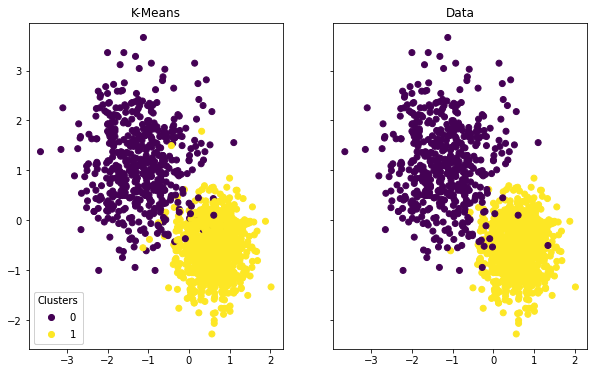

In [50]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,6))

ax1.set_title("K-Means")
sc1 = ax1.scatter("length", "margin_low", data=data_scaled, c=kmeans_pred)
legend1 = ax1.legend(*sc1.legend_elements(),
                    loc="lower left", title="Clusters")
ax1.add_artist(legend1)

ax2.set_title("Data")
sc2 = ax2.scatter("length", "margin_low", data=data_scaled, c="is_genuine")

Visuellement le résultats semblent plutôt bon. En reprenant les observations réalisées plus tôt on comprend que le **cluster 0 correspond aux faux billets** et que le **cluster 1 correspond aux vrais billets**.

Étudions de plus près ces résultats:

> **Matrice de confusion:**

In [51]:
kmeans_conf = confusion(data_scaled.is_genuine, kmeans_pred)
kmeans_conf

,pred_0,pred_1
test_0,486,14
test_1,10,990


Au vu de la matrice de confusion ce modèle est bien meilleur que notre modèle de base (DummyClassifier) mais ils produits tout de même quelques erreurs.

In [52]:
tn = kmeans_conf.iloc[0][0]
tp = kmeans_conf.iloc[1][1]
fp = kmeans_conf.iloc[0][1]
fn = kmeans_conf.iloc[1][0]
print(tp, tn, fp, fn)

990 486 14 10


> **Accuracy Score**:

Proportion de bonnes prédictions sur le totale des prédictions réalisées.

In [53]:
kmeans_accu = (tp+tn) / (tp+tn+fp+fn)
kmeans_accu

0.984

> Score de **Sensibilité**:

Mesure la proportion de bonnes prédictions parmis les "vrais billets".

In [54]:
kmeans_sens = round(tp/(tp+fn),4)
kmeans_sens

0.99

> Score de **Spécificité**:

Mesure la proportion de bonnes prédictions parmis les "faux billets".

In [55]:
kmeans_spec = round(tn/(tn+fp),4)
kmeans_spec

0.972

> Score de **Précision**:

Mesure la proportion de véritables "vrais billets" parmis ceux prédis comme "vrais".

In [56]:
kmeans_prec = round(tp/(tp+fp),4)
kmeans_prec

0.9861

> **Courbe ROC**:

In [57]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(data_scaled.is_genuine, kmeans_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.981

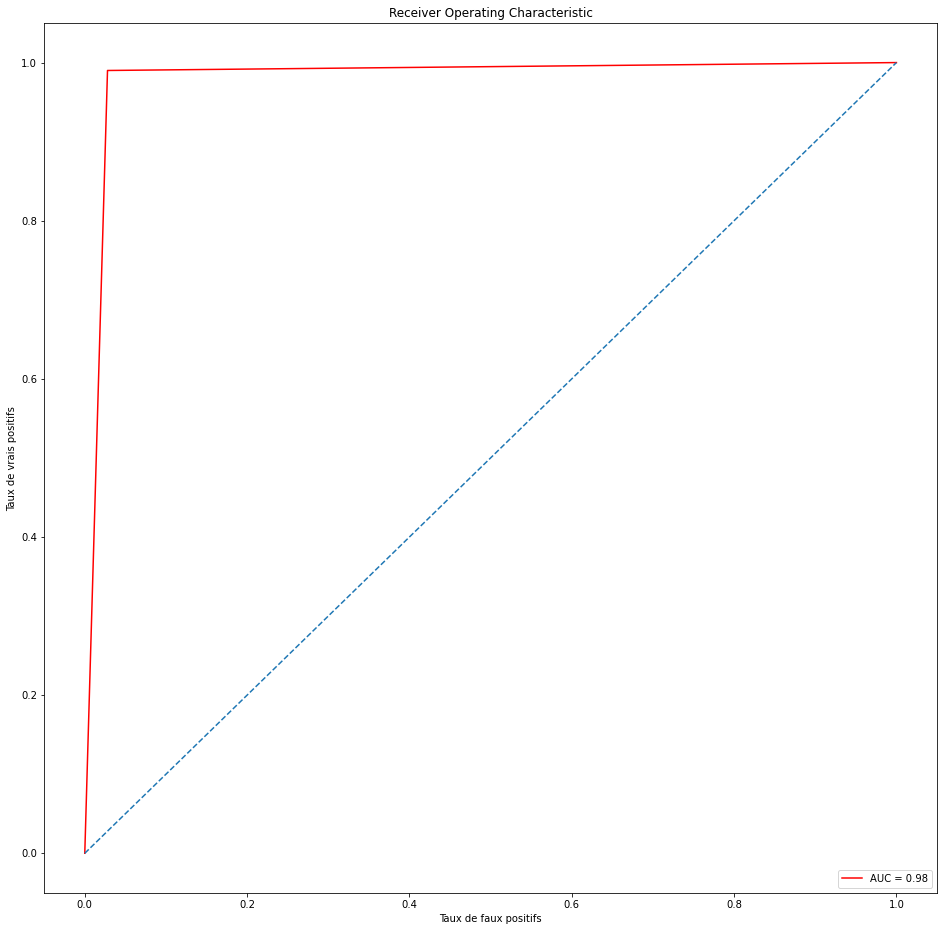

In [58]:
plt.figure(figsize=(16,16))
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate, color="red", label = "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.axis("tight")
plt.ylabel("Taux de vrais positifs")
plt.xlabel("Taux de faux positifs")
plt.show()

Nous avons ici un modèle avec des performances relativement satifaisantes. 

Afin d'avoir un dernier point de comparaison avec d'autres modèles, testons le sur notre jeu de données *"production"*:

In [59]:
# on normalise les données "production":
data_prod_scaled = scaler.fit_transform(data_prod[["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]])
data_prod_scaled = pd.DataFrame(data_prod_scaled, index=data_prod.index, columns=["diagonal", 
                                                                        "height_left",
                                                                        "height_right",
                                                                        "margin_low", 
                                                                        "margin_up", 
                                                                        "length"])
data_prod_scaled

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.664228,-0.502224,-1.228900,0.438224,0.485681,-1.124014
1,-0.287604,-0.050787,0.449459,1.493702,0.564017,-0.289103
2,0.157497,1.106022,0.904607,0.144293,1.190702,-0.937094
3,1.835186,1.021377,1.046841,-0.590533,-1.629382,1.094107
4,-1.040852,-1.574388,-1.172007,-1.485686,-0.611018,1.256104


In [60]:
# on récupère les prédictions du modèle:
data_prod["is_genuine"] = kmeans.predict(data_prod_scaled)
data_prod["is_genuine"] = data_prod["is_genuine"].astype("bool")
print(data_prod[["id", "is_genuine"]])

    id  is_genuine
0  A_1       False
1  A_2       False
2  A_3       False
3  A_4        True
4  A_5        True


Le modèle K-Means nous permet d'identifier trois billets comme faux (A_1, A_2 & A_3) et deux billets comme vrais (A_4 & A_5).

***

Essayons maintenant de créer un autre modèle et comparons les résultats obtenus afin de retenir le plus performant et pertinent.

### 3. Regression Logistique: <a class="anchor" id="section_3_3"></a>

In [61]:
# on paramètre et on entraine le modèle:
log_reg_1 = LogisticRegression() #on laisse les paramètres par défaut dans un premier temps
log_reg_1.fit(X_train, y_train)

LogisticRegression()

In [62]:
# on récupère les prédictions:
y_pred = log_reg_1.predict(X_test)
y_pred

array([False, False,  True,  True,  True,  True, False,  True, False,
        True,  True, False,  True, False,  True, False, False,  True,
        True,  True, False, False,  True, False, False,  True, False,
       False, False, False, False,  True, False, False,  True,  True,
        True,  True, False,  True, False,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False, False,  True,  True,  True, False,
        True,  True,  True, False, False,  True,  True,  True, False,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True, False, False,  True,  True, False,
       False,  True,

In [63]:
# on récupère les probabilités:
y_prob = log_reg_1.predict_proba(X_test).round(2)
y_prob_df = pd.DataFrame(y_prob)
y_prob_df

,0,1
0,1.00,0.00
1,1.00,0.00
2,0.00,1.00
3,0.00,1.00
4,0.00,1.00
...,...,...
295,0.00,1.00
296,0.01,0.99
297,1.00,0.00
298,0.91,0.09


***

### **Étude des résultats:**

> **Matrice de confusion:**

In [64]:
log_reg_1_conf = confusion(y_test, y_pred)
log_reg_1_conf

,pred_0,pred_1
test_0,108,2
test_1,0,190


La matrice de confusion présente des résultats très satisfaisant. 

Calculons différents score afin de comparer les performances de ce modèles avec le précédent.

***

In [65]:
tn = log_reg_1_conf.iloc[0][0]
tp = log_reg_1_conf.iloc[1][1]
fp = log_reg_1_conf.iloc[0][1]
fn = log_reg_1_conf.iloc[1][0]
print(tp, tn, fp, fn)

190 108 2 0


> **Accuracy Score**:

In [66]:
score(log_reg_1)

score train: 0.9908 score test: 0.9933


> Score de **Sensibilité**:

In [67]:
log_reg_1_sens = round(tp/(tp+fn),4)
log_reg_1_sens

1.0

> Score de **Spécificité**:

In [68]:
log_reg_1_spec = round(tn/(tn+fp),4)
log_reg_1_spec

0.9818

> Score de **Précision**:

In [69]:
log_reg_1_prec = round(tp/(tp+fp),4)
log_reg_1_prec

0.9896

> **Courbe ROC:**

In [70]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9909090909090909

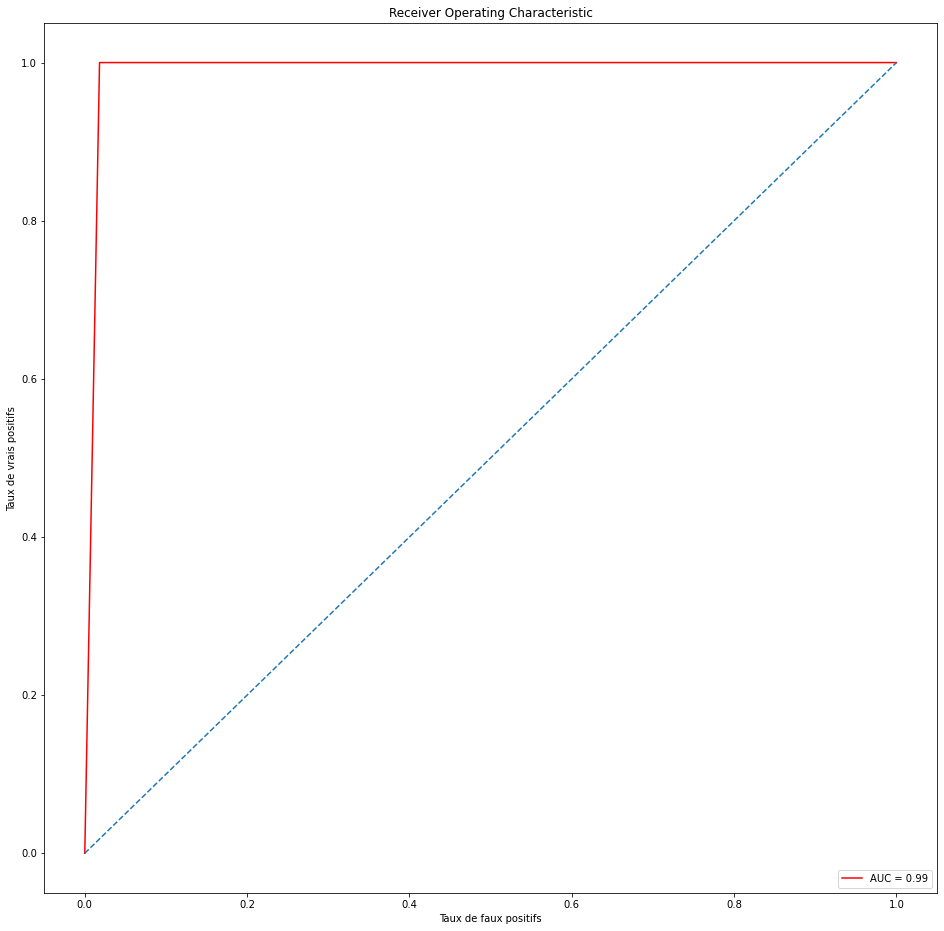

In [71]:
plt.figure(figsize=(16,16))
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate, color="red", label = "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.axis("tight")
plt.ylabel("Taux de vrais positifs")
plt.xlabel("Taux de faux positifs")
plt.show()

Ce modèle semble très performant, et l'évaluation de ses résultats indique qu'il est même **surement plus intéressant que le modèle K-Means**.

***

Nous pouvons aussi procéder à la validation croisée de notre modèle afin de s'assurer de sa robustesse.

> **Validation Croisée:**

La validation croisée, en faisant une moyenne des scores obtenus sur les différentes partitions, va nous permettre confirmer la robustesse de notre score (et donc du modèle).

In [72]:
params = {} # on utilise les paramètres par défaut   

In [73]:
grid = GridSearchCV(log_reg_1,
                    params,
                    cv=10, # nombre de folds utilisés pour la validation croisée
                    n_jobs=-1, # optimisation de l'utilisation des CPU
                    return_train_score=True,
                    verbose=1)
grid.fit(data_scaled.drop(columns="is_genuine"), data_scaled.is_genuine)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1, param_grid={},
             return_train_score=True, verbose=1)

In [74]:
res = grid.cv_results_
res_df = pd.DataFrame(res)
res_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.018052,0.004558,0.002295,0.000638,{},0.993333,0.986667,0.986667,0.986667,1.0,...,0.992593,0.992593,0.99037,0.992593,0.991111,0.99037,0.992593,0.991852,0.991704,0.000864


Nous pouvons afficher les scores obtenus pour chaque split différents réalisés:

In [75]:
res

{'mean_fit_time': array([0.01805224]),
 'std_fit_time': array([0.0045581]),
 'mean_score_time': array([0.00229487]),
 'std_score_time': array([0.00063768]),
 'params': [{}],
 'split0_test_score': array([0.99333333]),
 'split1_test_score': array([0.98666667]),
 'split2_test_score': array([0.98666667]),
 'split3_test_score': array([0.98666667]),
 'split4_test_score': array([1.]),
 'split5_test_score': array([0.99333333]),
 'split6_test_score': array([0.99333333]),
 'split7_test_score': array([0.98666667]),
 'split8_test_score': array([0.98666667]),
 'split9_test_score': array([0.99333333]),
 'mean_test_score': array([0.99066667]),
 'std_test_score': array([0.00442217]),
 'rank_test_score': array([1]),
 'split0_train_score': array([0.99111111]),
 'split1_train_score': array([0.99185185]),
 'split2_train_score': array([0.99259259]),
 'split3_train_score': array([0.99259259]),
 'split4_train_score': array([0.99037037]),
 'split5_train_score': array([0.99259259]),
 'split6_train_score': arra

Nous avons confirmation que le score obtenu initialement n'était pas un cas particulier. Tous les scores test obtenus sont supérieur à 0.99, pour un score moyen de 0.9917.

Comme nous l'avons vu, ce **modèle commet très peu d'erreurs**, mais il serait préférable que celles-ci soit des Faux Négatifs plutôt que des Faux Positifs. En effet notre modèle semble parfaitement identifier les vrais billets, cependant **il lui arrive de considérer certains faux billets comme vrais**. Nous privilégions le fait d'être trop précautionneux plutôt que pas assez et souhaitons ainsi **réduire au maximum le nombre de Faux Positif**. Pour cela, nous allons tester 2 méthodes:
- chercher des paramètres qui permettent de maximiser le score de Spécificité
- chercher un nouveau seuil vrai/faux

### **Amélioration du modèle:**

> **Recherche de paramètres:**

Nous allons ici tester plusieurs combinaisons de paramètres afin d'identifier si l'un d'entre eux permet de maximiser la score de Spécificité.

In [76]:
log_reg_test = LogisticRegression()

params = { "C": np.logspace(-3, 3, 7),
           "penalty": ["l1", "l2"],
           "solver": ["newton-cg", "lbfgs", "liblinear"]
         }

scorers = { "spec_score": make_scorer(recall_score,pos_label=0) # on veut calculer ici le score de spécificité
          }

In [77]:
refit_score = "spec_score"

grid = GridSearchCV(log_reg_test,
                    params,
                    scoring=scorers,
                    refit=refit_score,
                    cv=10,
                    n_jobs=-1,
                    return_train_score=True,
                    verbose=1)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 42 candidates, totalling 420 fits


D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'no

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             refit='spec_score', return_train_score=True,
             scoring={'spec_score': make_scorer(recall_score, pos_label=0)},
             verbose=1)

In [78]:
resultize(grid).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,mean_test_spec_score,std_test_spec_score,rank_test_spec_score,mean_train_spec_score,std_train_spec_score
2,0.017853,0.011288,0.006683,0.003625,0.001,l1,liblinear,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",1.000000,0.000000,1,1.000000,0.000000
5,0.006484,0.001023,0.005384,0.002863,0.001,l2,liblinear,"{'C': 0.001, 'penalty': 'l2', 'solver': 'libli...",0.984615,0.012561,2,0.985185,0.001709
14,0.006482,0.003344,0.005185,0.002130,0.1,l1,liblinear,"{'C': 0.1, 'penalty': 'l1', 'solver': 'libline...",0.982051,0.016418,3,0.982051,0.001824
11,0.006881,0.001809,0.004489,0.000499,0.01,l2,liblinear,"{'C': 0.01, 'penalty': 'l2', 'solver': 'liblin...",0.982051,0.016418,3,0.982051,0.001824
17,0.005186,0.001164,0.004288,0.001612,0.1,l2,liblinear,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.979487,0.019188,5,0.981766,0.002279
8,0.005187,0.001324,0.004988,0.002318,0.01,l1,liblinear,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.979487,0.019188,5,0.980912,0.001824
20,0.005686,0.001672,0.004387,0.001557,1.0,l1,liblinear,"{'C': 1.0, 'penalty': 'l1', 'solver': 'libline...",0.976923,0.017949,7,0.981481,0.002297
23,0.006884,0.002728,0.004090,0.001513,1.0,l2,liblinear,"{'C': 1.0, 'penalty': 'l2', 'solver': 'libline...",0.976923,0.017949,7,0.981481,0.002297
26,0.004786,0.000746,0.003792,0.001073,10.0,l1,liblinear,"{'C': 10.0, 'penalty': 'l1', 'solver': 'liblin...",0.976923,0.017949,7,0.981481,0.002297
27,0.018051,0.002424,0.003490,0.000497,10.0,l2,newton-cg,"{'C': 10.0, 'penalty': 'l2', 'solver': 'newton...",0.976923,0.017949,7,0.981481,0.002297


Il semble qu'une combinaison de paramètre nous garantisse d'avoir un score de spécificité parfait. On peut isoler ces paramètres optimaux:

In [79]:
best_params = grid.best_params_
best_params

{'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}

Observons les résultats obtenus en utilisant ces paramètres:

In [80]:
log_reg_2 = LogisticRegression(**best_params)

log_reg_2.fit(X_train, y_train)
y_pred = log_reg_2.predict(X_test)
score(log_reg_2)

score train: 0.325 score test: 0.3667


In [81]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,110,0
test_1,190,0


Bien que ces paramètres nous garantissent un score de spécificité parfait et par conséquent de ne pas "manquer" de faux billets, on constate rapidement que ce modèle n'est pas viable. En effet son accuracy score est très peu élevé et pour cause, le modèle considère simplement tous les billets comme des faux. Cela n'apporterait rien par rapport à nos besoins.

> **Recherche d'un nouveau seuil**:

Un autre moyen, plus simple et direct, serait de modifier manuellement le seuil de probabilité à partir duquel l'algorithme considère un billet comme "vrai". Par défaut ce seuil est égal à 50%.

Effectuons quelques tests:

In [82]:
# on récupère les prédictions avec un threshold modifié:
y_pred_thre = Binarizer(threshold = 0.6).transform(log_reg_1.predict_proba(X_test))[:,1]

# on retourne la nouvelle matrice de confusion:
log_reg_1_conf_thre = confusion(y_test, y_pred_thre)
log_reg_1_conf_thre

,pred_0,pred_1
test_0,109,1
test_1,1,189


In [83]:
y_pred_thre = Binarizer(threshold = 0.7).transform(log_reg_1.predict_proba(X_test))[:,1]

log_reg_1_conf_thre = confusion(y_test, y_pred_thre)
log_reg_1_conf_thre

,pred_0,pred_1
test_0,109,1
test_1,2,188


In [84]:
y_pred_thre = Binarizer(threshold = 0.734).transform(log_reg_1.predict_proba(X_test))[:,1]

log_reg_1_conf_thre = confusion(y_test, y_pred_thre)
log_reg_1_conf_thre

,pred_0,pred_1
test_0,110,0
test_1,2,188


Après plusieurs itérations 0.734 semble être un seuil acceptable. En effet en s'assurant qu'un billet n'est vrai qu'à partir du moment ou sa probabilité de l'être est supérieur à 73.4% on limite fortement le risque de laisser passer un faux billet entre les mailles du filet.

La contrepartie étant que certains vrais billets, aux caractéristiques particulières, risquent d'être comptés comme faux par erreur. Mais cette erreur est minime.

***

On peut maintenant, comme avec le K-Means, tester le modèle sur nos données "production":

In [85]:
data_prod = pd.read_csv("billets_production.csv")

# on récupère les prédictions:
data_prod_pred = Binarizer(threshold = 0.734).transform(log_reg_1.predict_proba(data_prod_scaled))[:,1]
data_prod_prob = log_reg_1.predict_proba(data_prod_scaled)
data_prod_prob = pd.DataFrame(data_prod_prob)

# on récupère les prédictions du modèle:
data_prod["is_genuine"] = data_prod_pred
data_prod["is_genuine"] = data_prod["is_genuine"].astype("bool")
data_prod["proba_vrai(%)"] = round(data_prod_prob[1]*100,2)

print(data_prod[["id", "is_genuine", "proba_vrai(%)"]])

    id  is_genuine  proba_vrai(%)
0  A_1       False           5.50
1  A_2       False           1.68
2  A_3       False           0.90
3  A_4        True          99.98
4  A_5        True         100.00


On obtient des résutats semblables à ceux obtenus avec la méthode précédente et l'ajout de la probabilité permet de mettre à disposition une information importante.

> **Coefficients:**

On peut, à titre informatif, récupérer les coefficients de chaque variables:

In [86]:
log_reg_coeff = pd.DataFrame(np.concatenate([log_reg_1.intercept_.reshape(-1,1),
                             log_reg_1.coef_],axis=1),
                             index = ["coeff"],
                             columns = ["constante"]+list(data_scaled.drop(columns="is_genuine").columns)).T
log_reg_coeff

,coeff
constante,1.953049
diagonal,0.075798
height_left,-0.472872
height_right,-0.687097
margin_low,-2.559604
margin_up,-1.559296
length,3.513365


In [87]:
beta1 = log_reg_1.intercept_[0]
beta2 = log_reg_1.coef_[0,0]
beta3 = log_reg_1.coef_[0,1]
beta4 = log_reg_1.coef_[0,2]
beta5 = log_reg_1.coef_[0,3]
beta6 = log_reg_1.coef_[0,4]
beta7 = log_reg_1.coef_[0,5]

## IV) Choix du modèle et déploiement <a class="anchor" id="chapter1"></a>

> **Choix:**

Le modèle **K-Means** et **Regression Logistique** présentent tous les deux des résultats très satisfaisants. 

Cependant, au vu des résultats obtenus, de sa robustesse et de la possibilité de profiter d'informations supplémentaires nous allons retenir le modèle **"reg_log_1"** basé sur une régression logistique. Nous y appliquerons le seuil modifié identifié plus tôt afin de coller au mieux aux besoins de cet algorithme.

> **Déploiement:**

In [88]:
# enregistrement du modèle:
import pickle
pickle.dump(log_reg_1, open("RegLog_Model.pkl", "wb"))